# Deep Learning Summary Notebook

We ran a number of deep learning models. All deep learning models were trained on dataset with 200k samples. During their execution, I saved the results into a CSV file. In this notebook, we will look at results from our runs and compare results from our traditional ML model with deep learning prototypes

For a list of architectures tested, please see [Architectures Used](#architectures_used)
section of this notebook

The following dataset was used for all of our models:

* 200k samples of pre-processed amazon review body
    * Difference from dataset used in traditional ML model:
        * keep stop words
        * words were not lemmatized

Criteria for evaluation:

* We will use the same custom metric that was using for our traditional ML models so we can use one number to compare between models - this is a harmonic mean of precision for majority classes (1-star and 5-star) and recall for minority classes (2-star, 3-star, and 4-star)

    
# Conclusion

LSTM with balanced weight performed the best out of our deep learning model. Bidirectional GRU performed around the same as our LSTM network with balanced weights. However, training time for GRU is significantly longer. We will choose LSTM going forward

Settings for this model:
* LSTM Cell: 16
* Output Layer: Fully connected dense layer with sofmax output dimension of 5
* Class Weight: Balanced
* Optimizer: Adam with learning rate of 0.01
* Loss Fuction: categorical cross entropy
* Batch Size: 128
* Dropout Rate: 0
* Recurrent Dropout Rate: 0

While our LSTM network performed slightly worse than Logistic Regression (within 0.05 of our custom score), LSTM shows promise over large datasets as Logistic Regression scores for this notebook was trained with the full dataset of 9mil examples and has shown to plateau at arond 1mil to 2mil examples.






In [1]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib

import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=2)


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load report file form all of our deep learning models
REPORT_DIR = "../reports"
REPORT_FILE = "dl_prototype-report.csv"
report = ru.load_dnn_report(REPORT_DIR, REPORT_FILE, convert_format = True)

<a id='architectures_used'></a>
# Architectures Used

In [3]:
report[["model_name", "architecture", "description"]]

,model_name,architecture,description
0,LSTM16,1x16,"1 Layer 16 LSTM Units, unbalanced weights"
1,LSTMB16,1x16,"1 Layer 16 LSTM Units, balanced weights"
2,biLSTMB16,1x16,"1 Layer Bidirectional 16 LSTM Units, balanced ..."
3,GRU16,1x16,"1 Layer 16 GRU units, unbalanced weights"
4,GRUB16,1x16,"1 Layer 16 GRU units, balanced weights"
5,biGRUB16,1x16,"1 Layer Bi-directional GRU (16 units), balance..."


In [4]:
# load best model from traditional ML model
ML_REPORT_FILE = "201911-pyspark-report.csv"

ml_report = ru.load_dnn_report(REPORT_DIR, ML_REPORT_FILE, convert_format = True)

# flatten out classification report so we can graph later
ml_report = ru.convert_dnn_report_format(ml_report)

ml_best = ru.load_best_from_report(ml_report)

print(f'Score for our best model: {ml_best.iloc[0].eval_metric}')

Score for our best model: 0.5174674207704685


In [5]:
# construct a temporary DF so we can plot the score for our best ML model
ml_plot_df = pd.DataFrame(report.display_name)
ml_plot_df['ml_score'] = ml_best.iloc[0].eval_metric

Best Score: 0.4737719730775922



,display_name,sampling_type,eval_metric
0,LSTM16 (1x16),none,0.283666
1,LSTMB16 (1x16),none,0.473772
2,biLSTMB16 (1x16),none,0.446196
3,GRU16 (1x16),none,0.153365
4,GRUB16 (1x16),none,0.437440
5,biGRUB16 (1x16),none,0.444997


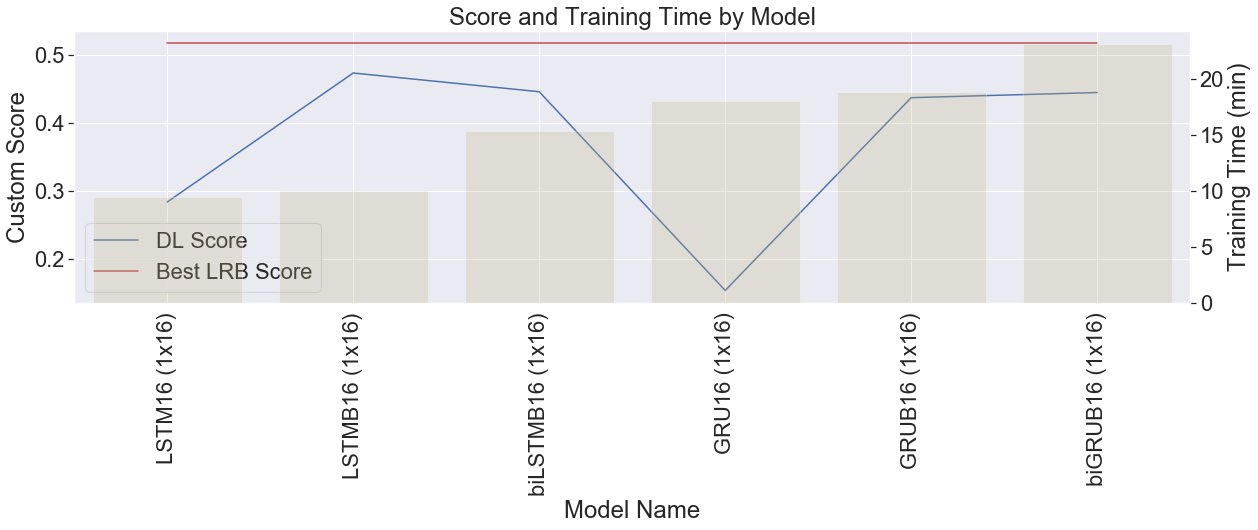

In [13]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
# Plot results from DL models
a = sns.lineplot(data = report, x = "display_name", y = "eval_metric", sort = False, label="DL Score")
# Plot out score from best ML report
a = sns.lineplot(data = ml_plot_df, x = "display_name", y = "ml_score", sort = False, 
                 label="Best LRB Score", linestyle="--", color="r")
_ = plt.xlabel("Model Name")
_ = plt.ylabel("Custom Score")
_ = plt.xticks(rotation=90)

a2 = a.twinx()
_ = sns.barplot(data = report, x = "display_name", 
                y = "train_time_min", 
#                 sort = False, 
                alpha = 0.25,
                ax=a2, 
                label="Training Time", color="y")
_ = plt.ylabel("Training Time (min)")
a2.grid(False)

_ = plt.title("Score and Training Time by Model")


print(f'Best Score: {report.eval_metric.max()}\n')
report[["display_name", "sampling_type", "eval_metric"]]

# Compare Best DL Model (LSTMB) With Logistic Regression (PySpark)

* Logistic Regression Generally has better Precision
* Logistic Regression generally has better Recall with the exception of 3-star ratings

NOTE: Logistic Regression was trained with the full dataset (9 mil samples) whereas for this notebook, all deep learning models were trained with only 200k samples

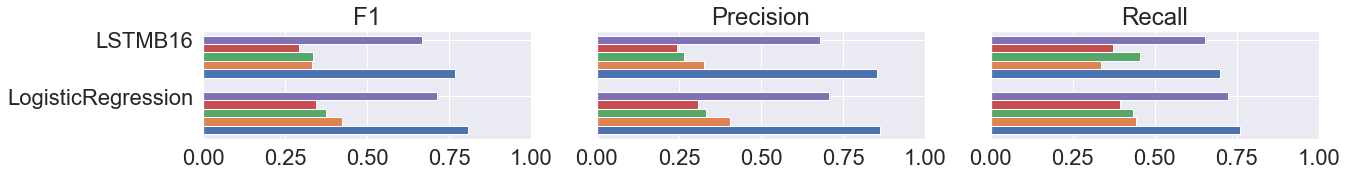

In [11]:
dl_best = ru.load_best_from_report(report)

combined_best = ml_best.append(dl_best, ignore_index=True)
pu.plot_score_histograms(combined_best, version=2, label="model_name", sort=False)
